# DTSA 5509 FINAL PROJECT
GitHub link: https://github.com/jhoglund1/DTSA-5509

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier

import piplite
await piplite.install('seaborn')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## DATA INGESTION

For this project, the data used is from the UCI Machine Learning Repository (source below). The data was collected from various hospitals, clinics, and maternal heath care centers in rural areas in Bangladesh. It provides information in order to measure risk for maternal mortality from 6 numerical features: Age, Systolic Blood Pressure (SystolicBP), Diastolic Blood Pressure (DiastolicBP), Blood Sugar (BS), Body Temperature (BodyTemp), and Heart Rate (HeartRate). The categorical target feature is labelled as RiskLevel and has three categories: Low Risk, Medium Risk, and High Risk. There 1014 total instances.

Source:
Ahmed, M. (2020). Maternal health risk. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/863/maternal+health+risk 

In [3]:
# Read in dataset
data = pd.read_csv('Maternal Health Risk Data Set.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 51.6+ KB


## DATA CLEANING

##### Check for null values in dataset
No null values exist in this dataset so no rows need to be dropped.

In [4]:
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

##### Refactor target feature
Refactor RiskLevel feature from strings to ints in order calculate the score for the created models. Mapping is: 0 - Low Risk, 1 - Med Risk, 2 - High Risk

In [5]:
data['RiskLevel'] = data['RiskLevel'].map({'low risk':0, 'mid risk':1, 'high risk':2}).astype(int)

##### Check for categorical data imbalances
For the only categorical feature, we will print the percentage for how many of each category exist in the dataset as well as plot the counts for each risk level for visualization.
Low Risk has the highest amount of instances with 40% of the total amount while High Risk has the lowest amount with ~27% of the instances. 
While the categories are not evenly split, there is still a good amount of the High Risk category (> 15%), so no imbalance adjustments for High Risk need to occur.

0    0.400394
1    0.331361
2    0.268245
Name: RiskLevel, dtype: float64


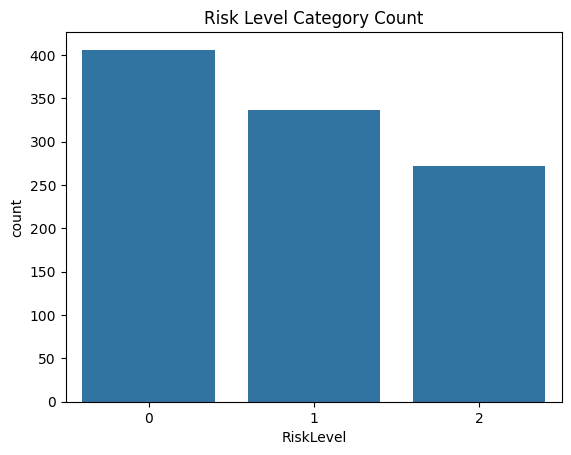

In [6]:
print(data['RiskLevel'].value_counts() / len(data))
sns.countplot(data, x='RiskLevel').set_title('Risk Level Category Count')
plt.show()

##### Check for numerical data imbalances

Plot a box plot with the 6 numerical features. There is a small outlier for Age but it is very close to the upper quartile so it is reasonable to keep it. There are no outliers for DiastolicBP. The outliers for SystolicBP, BS, BodyTemp, and HeartRate are considered below.

<AxesSubplot:>

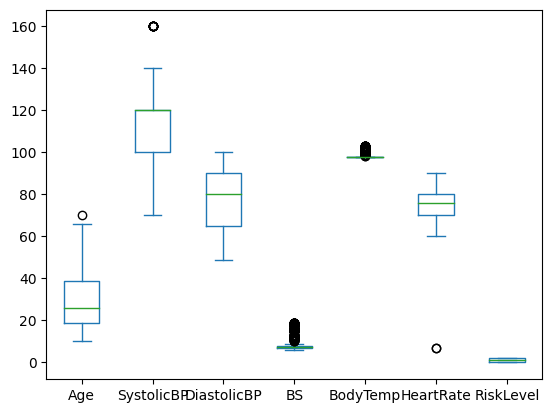

In [7]:
data.plot(kind='box')

###### Check SystolicBP outliers

The boxplot shows an outlier around 160. A further look at SystolicBP's greater than 150 show that there are 10 rows where the SystolicBP is 160. Further research says that 160 is an approprirate possible value for SystolicBP, so these rows can stay.

<AxesSubplot:>

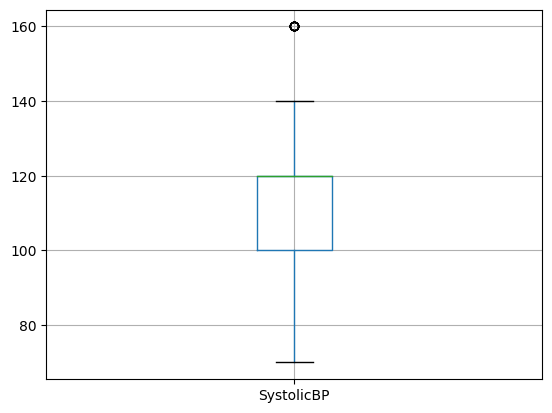

In [8]:
data.boxplot(['SystolicBP'])

In [9]:
data.loc[(data['SystolicBP'] >= 150)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.0,98.0,77,2
130,40,160,100,19.0,98.0,77,2
166,40,160,100,19.0,98.0,77,2
262,40,160,100,19.0,98.0,77,2
362,40,160,100,19.0,98.0,77,2
538,40,160,100,19.0,98.0,77,2
583,40,160,100,19.0,98.0,77,2
689,40,160,100,19.0,98.0,77,2
961,40,160,100,19.0,98.0,77,2
994,40,160,100,19.0,98.0,77,2


###### Check HeartRate outliers

The boxplot shows an outlier below 10. A further look at HeartRate's less than 40 show that there are 2 instances where the HeartRate is 7. This is an essentially impossible value for a heart rate. Since there are only 2 instances these rows can just be removed from the dataset.

<AxesSubplot:>

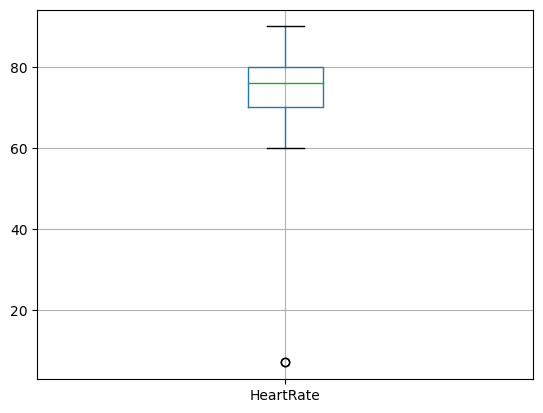

In [10]:
data.boxplot(['HeartRate'])

In [11]:
data.loc[(data['HeartRate'] < 40)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,0
908,16,120,75,7.9,98.0,7,0


In [12]:
data = data.drop(data[data['HeartRate'] == 7].index)

###### Check BS outliers

The boxplot shows several outliers ranging from 10 to ~19. A further look at Blood Sugar values less than 10, show that there are 210 instances of high BS levels. Further research shows that all these outliers can be realistic values for Blood Sugar, so all these outliers can stay in the dataset.

<AxesSubplot:>

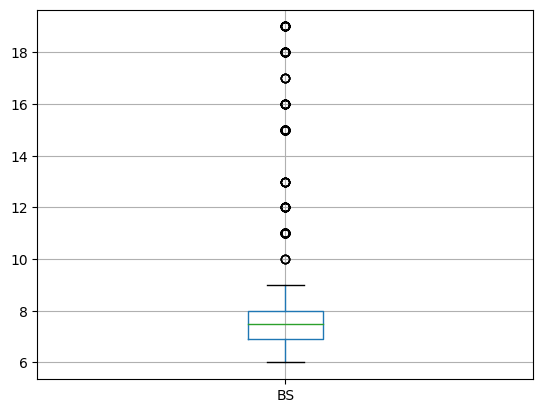

In [13]:
data.boxplot(['BS'])

In [14]:
data.loc[(data['BS'] >= 10)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
7,35,85,60,11.0,102.0,86,2
9,42,130,80,18.0,98.0,70,2
14,48,120,80,11.0,98.0,88,1
...,...,...,...,...,...,...,...
1008,48,120,80,11.0,98.0,88,2
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2


###### Check BodyTemp outliers

The boxplot shows several outliers ranging from >98 to 103. A further look at BodyTemp levels greater than 98, show that there are 210 instances of high Body Temperatur levels. All these values are realistic options for Body Temperature, so all these outliers can stay in the dataset.

<AxesSubplot:>

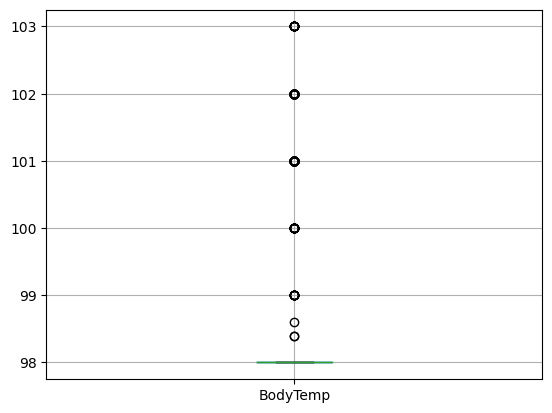

In [15]:
data.boxplot(['BodyTemp'])

In [16]:
data.loc[(data['BodyTemp'] > 98)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
2,29,90,70,8.00,100.0,80,2
7,35,85,60,11.00,102.0,86,2
13,20,120,75,7.01,100.0,70,1
18,30,120,80,6.90,101.0,76,1
35,12,95,60,6.10,102.0,60,0
...,...,...,...,...,...,...,...
1000,12,90,60,11.00,102.0,60,2
1004,13,90,65,9.00,101.0,80,2
1005,17,90,65,7.70,103.0,67,2
1006,17,85,60,6.30,102.0,86,2


#### Data Cleaning Summary

This dataset was relatively clean. No nan values existed. There were 2 outliers in the BS feature that gave impossible values, so those 2 rows containing the outliers were removed. The outliers were accessed and determined to be realistic values. The target feature was checked for data imbalance and determined to be appropriately balanced. The categories for the target were changed to numerical representations to aid in model evaluation later. It will be essential to carry the mapping forward throughout the experiment in order to properly associate the number to the risk level. Info and descriptions for the cleaned dataset is below.

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   SystolicBP   1012 non-null   int64  
 2   DiastolicBP  1012 non-null   int64  
 3   BS           1012 non-null   float64
 4   BodyTemp     1012 non-null   float64
 5   HeartRate    1012 non-null   int64  
 6   RiskLevel    1012 non-null   int32  
dtypes: float64(2), int32(1), int64(4)
memory usage: 59.3 KB


In [18]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,29.899209,113.184783,76.463439,8.727619,98.666403,74.434783,0.869565
std,13.473560,18.419618,13.899372,3.296583,1.372421,7.521857,0.807227
min,10.000000,70.000000,49.000000,6.000000,98.000000,60.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


## EXPLORATORY DATA ANALYSIS

##### Histogram
The histogram plotted below shows that Age has a right skewed somewhat normal distribution. The other 4 features have data that is spread out enough so as to not be able to make any assumptions about the distribution of each feature. The HeartRate feature has a large gap of reported heart rates between ~ 72 and 75. It seems unusual that there would be no heart rates reported at the potential peak of the distribution. This appears to possibly be a rounding error in the data collection process. It doesn't seem to be too impactful for the overall models but we will keep it in mind if Heart Rate is an important feature.

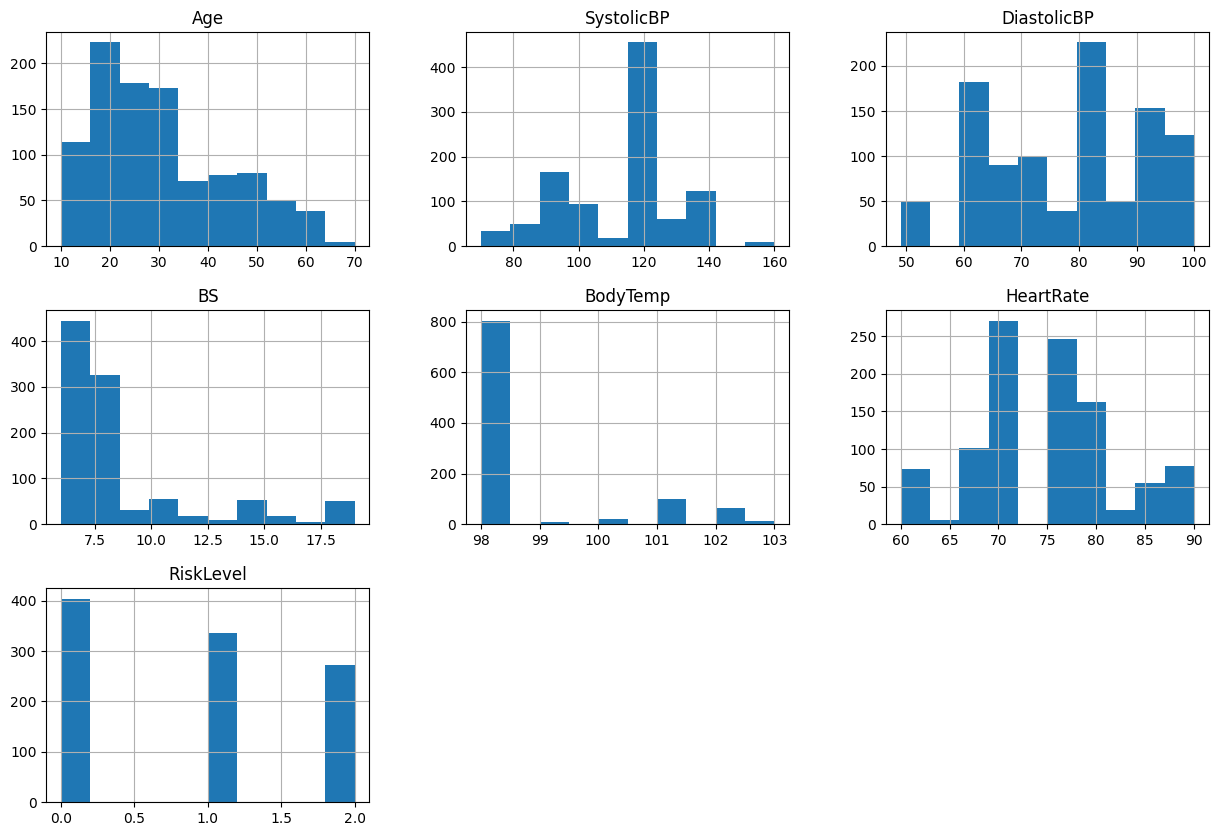

In [19]:
data.hist(figsize=(15, 10))
plt.show()

##### Pairwise Plot

The pairwise plot shows that most of the feature pairs have relatively evenly distributed data points, which shows no collinearity between the features. The pairs relating to BS have some bunching in the lower part of the charts but this makes sense since the majority of the BS values are on the lower end. There may a slight linear relationship between SystolicBP and DiastolicBP, which we will pay attention to in the correlation matrix chart further below. 

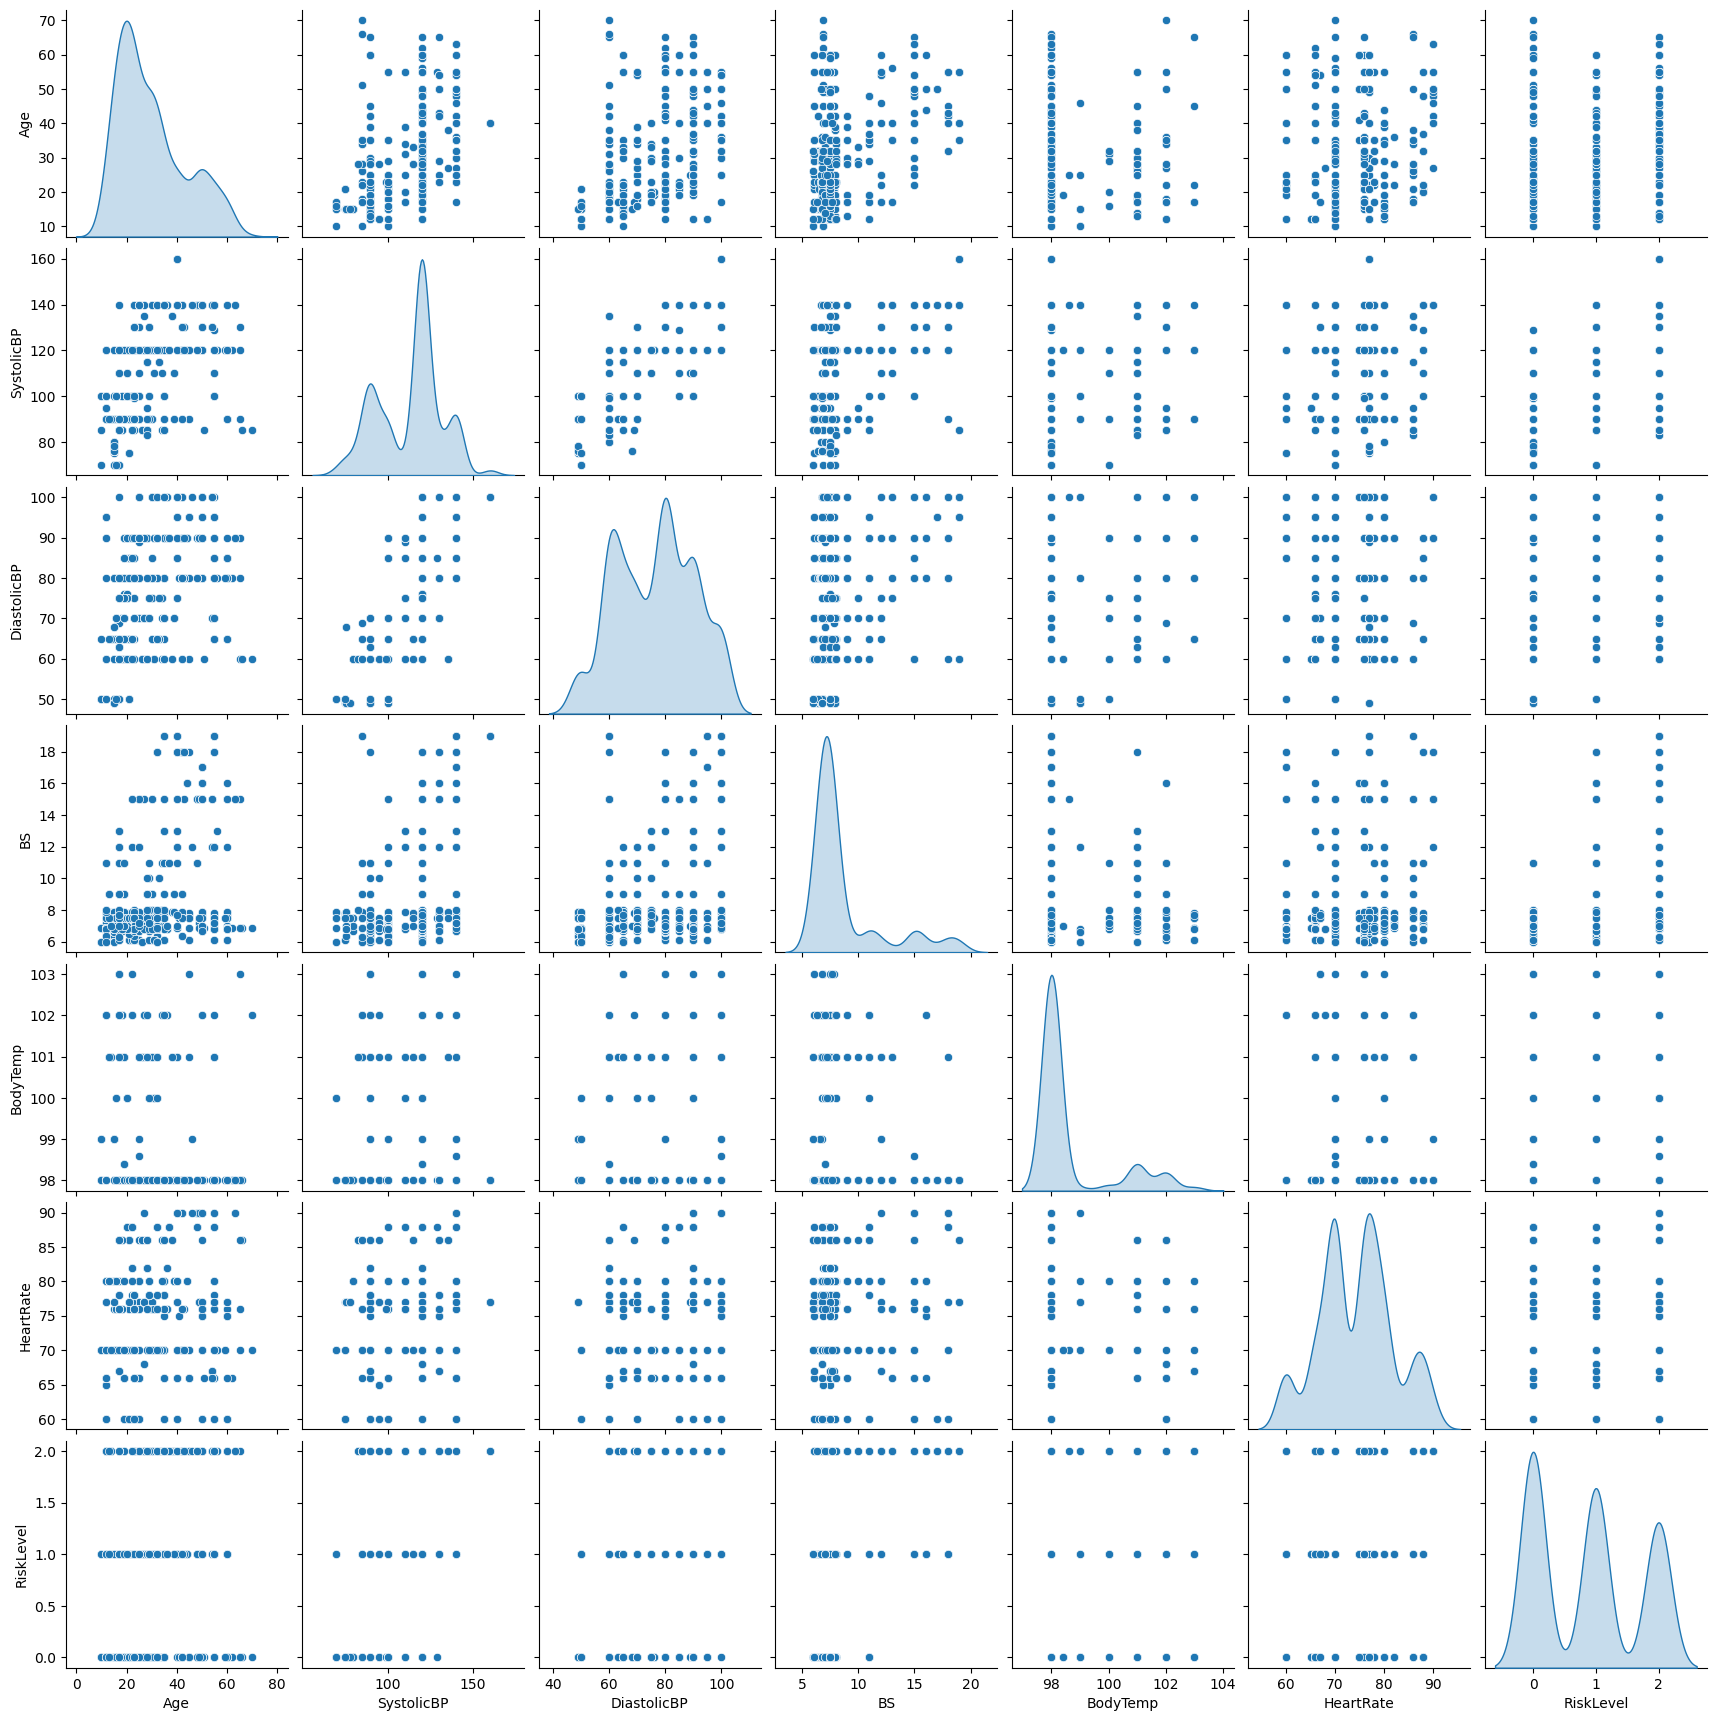

In [21]:
sns.pairplot(data, diag_kind = "kde")
plt.show()

##### Correlation Matrix
The correlation matrix heatmap below shows several things. First, there is a higher correlation between BS (blood sugar) and the target variable, RiskLevel. It is not quite enough to be considered highly correlated, but we will note that BS appears to be the most important feature for assessing RiskLevel. There is also a high correlation between the SystolicBP and DiastolicBP features. This makes sense since those are the two part of a blood pressure measurement that are always taken together. In order to remove the this highly correlated relationship, we will remove DiastolicBP from the dataset, since research suggests that SystolicBP is the most important blood pressure measurement (https://pubmed.ncbi.nlm.nih.gov/12698068/#:~:text=In%20this%20review%20we%20compare,a%20better%20predictor%20of%20risk). 

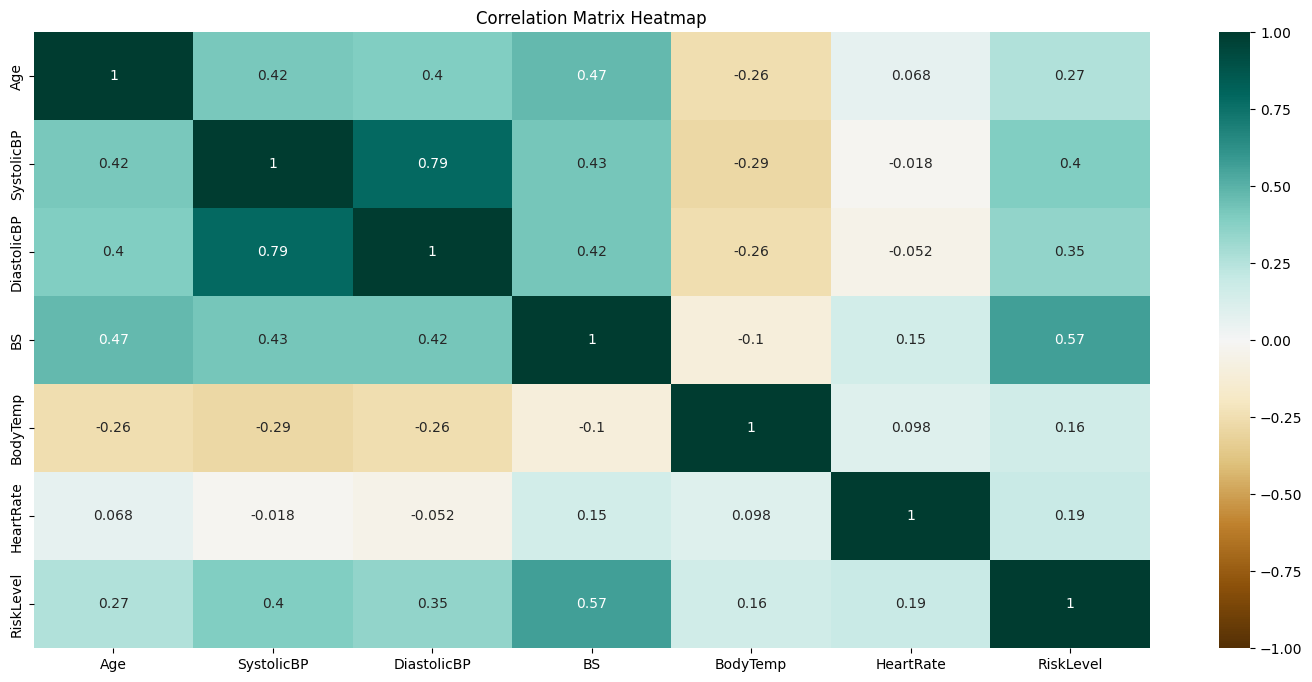

In [22]:
plt.figure(figsize=(18, 8))
hmap = sns.heatmap(data.corr(), annot = True, vmin = -1, vmax = 1, cmap = "BrBG")
hmap.set_title('Correlation Matrix Heatmap')
plt.show()

In [23]:
data = data.drop(['DiastolicBP'], axis=1)

### EDA Summary

* The histogram revealed make different data structures across the features, so no common distribution can be assumed for the dataset.There is a small discrepancy with the HeartRate feature that is noted.
* The pairwise plot showed evenly distributed data points across most of the feature pairs, except for the SystolicBP and DiastolicBP pair which showed a slightly linear relationship.
* The correlation matrix showed a slightly high correlation between BS and RiskLevel. It was not high enough to remove, but was noted for further analysis. The heatmap also showed a high correlation between the SystolicBP and DiastolicBP features. The DiastolicBP feature was removed from the dataset in order to eliminate that colinear relationship. Information about the dataset after the updates is below.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1012 non-null   int64  
 1   SystolicBP  1012 non-null   int64  
 2   BS          1012 non-null   float64
 3   BodyTemp    1012 non-null   float64
 4   HeartRate   1012 non-null   int64  
 5   RiskLevel   1012 non-null   int32  
dtypes: float64(2), int32(1), int64(3)
memory usage: 51.4 KB


## MODELS

##### Models Choosen
The classifiers tested against this dataset are k Nearest Neighbors, Decision Tree Classifier, Random Forest Classifier, and Gradient Boosting Classifier. All the classifier types are non-parametric. kNN uses a distance based data structure while the Decision Tree, Random Forest, and Gradient Boosting classifiers are all tree ensemble methods. These models were chosen to test the data against models of increasing levels of complexity.

##### Data Normalization and Test Train Split
The kNN model needs to use normalized data since it uses distances in order to calculate the classification. The code uses the MinMaxScaler in order to normalize the data. Train and test split datasets are created from the normalized data for the kNN classifier and from the non-normalized data for use in the other 3 classifiers.

In [25]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_data_minmax = MinMaxScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_data_minmax,columns=['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate'])

# normalized train and test sets
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y, test_size =0.2, random_state = 1)

# train and test set with regular data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#### kNN CLASSIFIER

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this classifier were n_neighbors, weights, and leaf_size. The n_neighbors parameter was cross validated with a range from 1 to 10. The weights parameter was cross validated with the two weight options, uniform and distance.  The leaf_size parameter was cross validated with a range from 10 to 50. The best parameters chosen for the classifier are listed below the code block.

In [26]:
knnParams = {'n_neighbors':[i for i in range(1,10,1)],
             'weights':['uniform', 'distance'],
             'leaf_size':[i for i in range(10,50,5)]}
knn = KNeighborsClassifier()
model_knn = GridSearchCV(knn, knnParams)
model_knn.fit(X_train_sc, y_train_sc)
y_pred_knn = model_knn.predict(X_test_sc)
print(model_knn.best_params_)

{'leaf_size': 45, 'n_neighbors': 9, 'weights': 'distance'}


##### Feature Importance
The KNeighborsClassifier library does not have a metric for feature importance since all the features are normalized.

#### DECISION TREE CLASSIFIER

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this classifier were criterion, max_depth, min_samples_split, min_samples_leaf, and max_features. The criterion parameter was cross validated with the three criterion options, gini, entropy, and log_loss. The max_depth parameter was cross validated with a range from 1 to 15. The min_samples_split parameter was cross validated with a range from 2 to 5, since a split minimum is 2. The min_samples_leaf parameter was cross validated with a range from 1 to 5. The max_features parameter was cross validated with a range from 1 to 5.  The best parameters chosen for the classifier are listed below the code block.

In [44]:
dtcParams = {'criterion':["gini", "entropy", "log_loss"],
             'max_depth':[i for i in range(1,15,1)],
             'min_samples_split':[i for i in range(2,5,1)],
             'min_samples_leaf':[i for i in range(1,5,1)],
             'max_features':[i for i in range(1,5,1)]}
dtc = DecisionTreeClassifier()
model_dtc = GridSearchCV(dtc, dtcParams)
model_dtc.fit(X_train, y_train)
y_pred_dtc = model_dtc.predict(X_test)
print(model_dtc.best_params_)

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


##### Feature Importance
The graph below shows the feature importance for each of the features in the Decision Tree Classifier. The BodyTemp feature was the least impactful while the BS feature was the most impactful. There is a difference of 0.353 between the least and most important feature. All the features have positive importance so they are all considered important to this model.

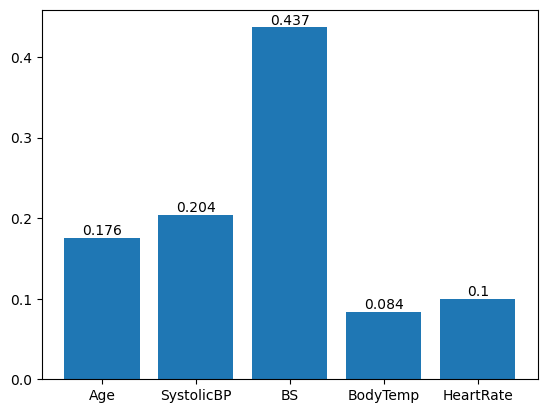

In [45]:
dtc_importance = []
for i in range(len(model_dtc.best_estimator_.feature_importances_)):
    dtc_importance.append(round(model_dtc.best_estimator_.feature_importances_[i],3))
    
plt.bar([x for x in range(len(dtc_importance))], dtc_importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,dtc_importance[i],dtc_importance[i], ha ='center', va = 'bottom')
plt.show()

#### RANDOM FOREST CLASSIFIER

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this classifier were criterion, max_depth, min_samples_split, min_samples_leaf, and max_features. The criterion parameter was cross validated with the three criterion options, gini, entropy, and log_loss. The max_depth parameter was cross validated with a range from 5 to 15. The min_samples_split parameter was cross validated with a range from 2 to 3, since a split minimum is 2. The min_samples_leaf parameter was cross validated with a range from 1 to 3.  The max_features parameter was cross validated with a range from 1 to 3. The range for the parameters was shortened from what the Decision Tree Classifier had in order to speed up the run time for the Random Forest Classifier. The best parameters chosen for the classifier are listed below the code block.

In [31]:
rfParams = {'criterion':["gini", "entropy", "log_loss"],
            'max_depth':[i for i in range(5,15,1)],
            'min_samples_split':[i for i in range(2,3,1)],
            'min_samples_leaf':[i for i in range(1,3,1)],
            'max_features':[i for i in range(1,3,1)],
            'n_jobs':[-1]}
rf = RandomForestClassifier()
model_rf = GridSearchCV(rf, rfParams)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print(model_rf.best_params_)

{'criterion': 'entropy', 'max_depth': 14, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_jobs': -1}


##### Feature Importance
The graph below shows the feature importance for each of the features in the Random Forest Classifier. The BodyTemp feature was the least impactful while the BS feature was the most impactful. There is a difference of 0.322 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

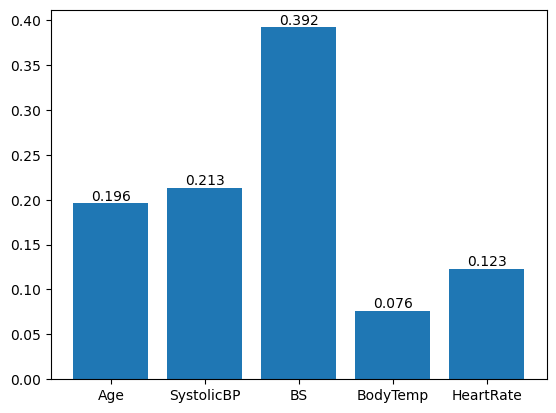

In [32]:
rf_importance = []
for i in range(len(model_rf.best_estimator_.feature_importances_)):
    rf_importance.append(round(model_rf.best_estimator_.feature_importances_[i],3))
    
plt.bar([x for x in range(len(rf_importance))], rf_importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,rf_importance[i],rf_importance[i], ha ='center', va = 'bottom')
plt.show()

### Gradient Boosting Classifier

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this classifier were max_depth, min_samples_split, min_samples_leaf, and max_features. The max_depth parameter was cross validated with a range from 5 to 10. The min_samples_split parameter was cross validated with a range from 2 to 5, since a split minimum is 2. The min_samples_leaf parameter was cross validated with a range from 1 to 5.  The max_features parameter was cross validated with a range from 1 to 5. The loss parameter only had the one option of log_loss in order to speed up the run time for the Gradient Boosting Classifier. The best parameters chosen for the classifier are listed below the code block.

In [33]:
gbParams = {'loss':['log_loss'],
            'max_depth':[i for i in range(5,10,1)],
            'min_samples_split':[i for i in range(2,5,1)],
            'min_samples_leaf':[i for i in range(1,5,1)],
            'max_features':[i for i in range(1,5,1)]}
gb = GradientBoostingClassifier()
model_gb = GridSearchCV(gb, gbParams)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
print(model_gb.best_params_)

{'loss': 'log_loss', 'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 3}


##### Feature Importance
The graph below shows the feature importance for each of the features in the Random Forest Classifier. The BodyTemp feature was the least impactful while the BS feature was the most impactful. There is a difference of 0.377 between the least and the most important feature. All the features have positive importance so they are all considered important to this model.

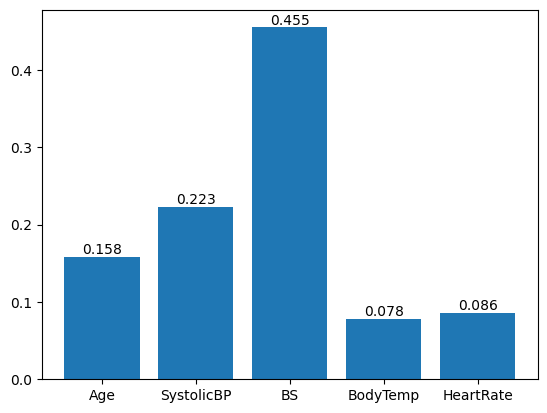

In [34]:
gb_importance = []
for i in range(len(model_gb.best_estimator_.feature_importances_)):
    gb_importance.append(round(model_gb.best_estimator_.feature_importances_[i],3))
    
plt.bar([x for x in range(len(gb_importance))], gb_importance)
plt.xticks([0,1,2,3,4],X.columns)
for i in range(len(X.columns)):
        plt.text(i,gb_importance[i],gb_importance[i], ha ='center', va = 'bottom')
plt.show()

### Models Summary

* 4 different models were trained, k Nearest Neighbors Classifier, Decision Tree Classifier, Random Forest Classifier, and Grandient Boosting Classifier.
* Train and test data sets were created from randomly split data. Data was normalized for the use in the kNN Classifier.
* Hyperparameter tuning and cross validation was conducted for several parameters in each model. The best performing parameters were saved for each model.
* All features were determined to be important to the three ensemble method classifiers. The order of importance lined up for each model, with BS being the most important feature, then SystolicBP, Age, HeartRate, and BodyTemp being the least important feature. The average difference between the most and least impactful features was 0.35 across the three models.

## RESULTS AND ANALYSIS

### Analysis

##### Confusion Matrices
The chart below displays the confusion matrices for each of the trained classifiers when assessing the predicted target values against the true values from the test set. All 4 models performed very similiarly in regards to the amount of correctly labeled categories. kNN has 173 instances in which the predicted label matched the true label. The Decision Tree Classifier had 174 instances, the Random Forest Classifier had 175 instances, and the Gradient Boosting Classifier had 177 instances. It appears that the Low Risk category was most often predicted as the Medium Risk category for all the models. The Medium Risk category was also often predicted as Low Risk.

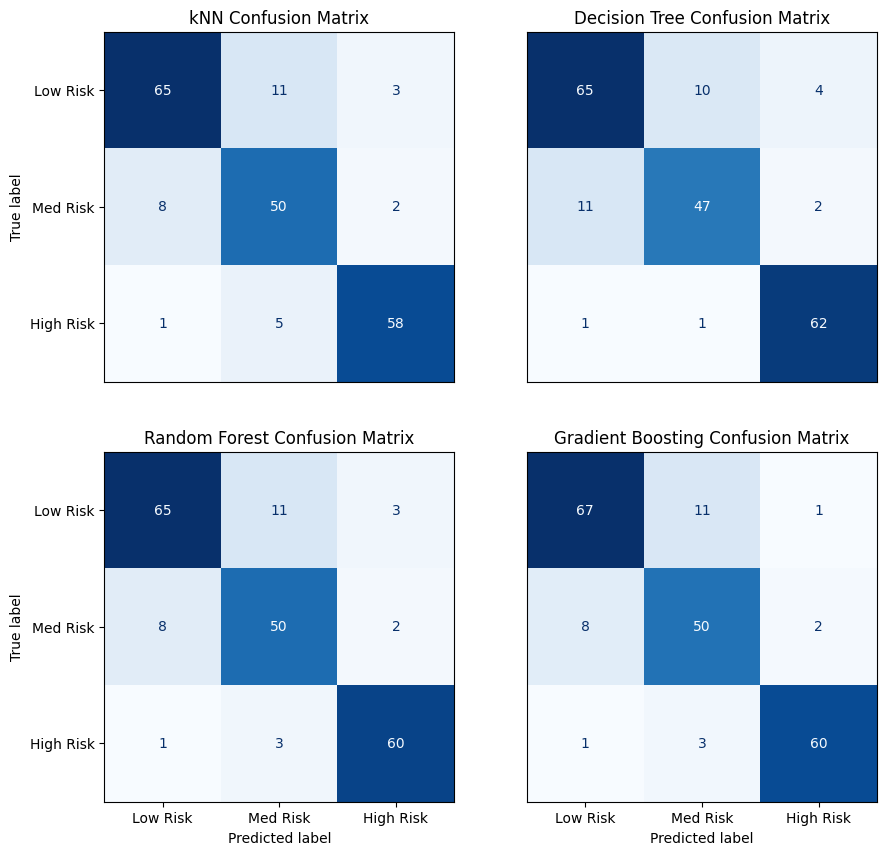

In [46]:
display_label = ['Low Risk', 'Med Risk', 'High Risk']
color = 'Blues'
colorbar = False

fig_cm, ax_cm = plt.subplots(2,2, figsize=(10,10))

ax_cm[0,0].set_title('kNN Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix(y_test_sc, y_pred_knn), display_labels = display_label).plot(cmap=color, ax=ax_cm[0,0], colorbar=colorbar)
ax_cm[0, 0].xaxis.set_ticklabels(['', '', ''])
ax_cm[0, 0].set_xlabel('')
ax_cm[0, 0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax_cm[0,1].set_title('Decision Tree Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dtc), display_labels = display_label).plot(cmap=color, ax=ax_cm[0,1], colorbar=colorbar)
ax_cm[0, 1].xaxis.set_ticklabels(['', '', ''])
ax_cm[0, 1].yaxis.set_ticklabels(['', '', ''])
ax_cm[0, 1].set_xlabel('')
ax_cm[0, 1].set_ylabel('')
ax_cm[0, 1].tick_params(axis='both', which='both', bottom=False, left=False)

ax_cm[1,0].set_title('Random Forest Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_rf), display_labels = display_label).plot(cmap=color, ax=ax_cm[1,0], colorbar=colorbar)
ax_cm[1, 0].tick_params(axis='y', which='both')

ax_cm[1,1].set_title('Gradient Boosting Confusion Matrix')
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_gb), display_labels = display_label).plot(cmap=color, ax=ax_cm[1,1], colorbar=colorbar)
ax_cm[1, 1].yaxis.set_ticklabels(['', '', ''])
ax_cm[1, 1].set_ylabel('')
ax_cm[1, 1].tick_params(axis='y', which='both',left=False)

plt.show()

##### Scores
The chart below displays the performance of all 4 models for accuracy, precision, recall, and F1 scores. All the models performed relatively well with an average score across all metrics around 0.86 with only a standard deviation of around 0.01. The kNN model performed the worst for accuracy, recall, and F1 while the Decision Tree Classifier performed the worse for precision. The Random Forest Classifier performed second best in all metrics and the Gradient Boosting Classifier performed the best in all metrics.

In [47]:
scores = [model_knn.score(X_test_sc, y_test_sc), 
          model_dtc.score(X_test, y_test), 
          model_rf.score(X_test, y_test), 
          model_gb.score(X_test, y_test)]
f1_scores = [f1_score(y_test_sc, y_pred_knn, average='weighted'), 
             f1_score(y_test, y_pred_dtc, average='weighted'), 
             f1_score(y_test, y_pred_rf, average='weighted'), 
             f1_score(y_test, y_pred_gb, average='weighted')]
precision_scores = [precision_score(y_test_sc, y_pred_knn, average='weighted'),
                    precision_score(y_test, y_pred_dtc, average='weighted'),
                    precision_score(y_test, y_pred_rf, average='weighted'),
                    precision_score(y_test, y_pred_gb, average='weighted')]
recall_scores = [recall_score(y_test_sc, y_pred_knn, average='weighted'),
                 recall_score(y_test, y_pred_dtc, average='weighted'),
                 recall_score(y_test, y_pred_rf, average='weighted'),
                 recall_score(y_test, y_pred_gb, average='weighted')]

def round_scores(scores_list):
    for s in range(len(scores_list)):
        scores_list[s] = round(scores_list[s], 3)

round_scores(scores)
round_scores(f1_scores)
round_scores(precision_scores)
round_scores(recall_scores)

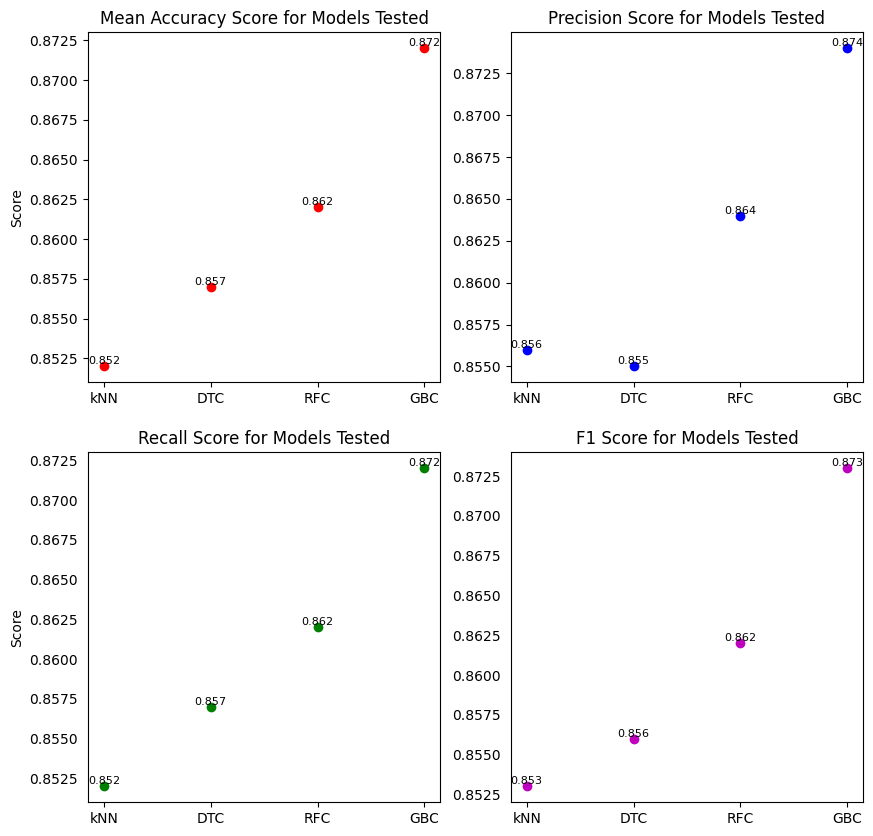

In [48]:
class_type = ['kNN', 'DTC', 'RFC', 'GBC']

fig_sc, ax_sc = plt.subplots(2,2, figsize=(10,10))

# Mean Accuracy
ax_sc[0,0].plot(class_type, scores, 'or')
for i in range(len(class_type)):
        ax_sc[0,0].text(i,scores[i],scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,0].set_xlabel('')
ax_sc[0,0].set_ylabel("Score")
ax_sc[0,0].set_title("Mean Accuracy Score for Models Tested")

# Precision
ax_sc[0,1].plot(class_type, precision_scores, 'ob')
for i in range(len(class_type)):
        ax_sc[0,1].text(i,precision_scores[i],precision_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,1].set_xlabel('')
ax_sc[0,1].set_ylabel('')
ax_sc[0,1].set_title("Precision Score for Models Tested")

# Recall
ax_sc[1,0].plot(class_type, recall_scores, 'og')
for i in range(len(class_type)):
        ax_sc[1,0].text(i,recall_scores[i],recall_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,0].set_ylabel('')
ax_sc[1,0].tick_params(axis='y', which='both',left=False)
ax_sc[1,0].set_ylabel("Score")
ax_sc[1,0].set_title("Recall Score for Models Tested")

# F1
ax_sc[1,1].plot(class_type, f1_scores, 'om')
for i in range(len(class_type)):
        ax_sc[1,1].text(i,f1_scores[i],f1_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,1].set_ylabel('')
ax_sc[1,1].tick_params(axis='y', which='both',left=False)
ax_sc[1,1].set_title("F1 Score for Models Tested")

plt.show()

##### ROC Curves
The chart below displays the ROC Curves and AUC values for each target category for each of the 4 classifiers. The AUC values for each category are comparable across all the models with only a 0.01 difference for AUC between models for the Low Risk and Medium Risk categories and the 0.02 difference for AUC between models for the High Risk category. The Decision Tree Classifier has the worse AUC values over all categories. The High Risk category had the highest AUC across all models with the Random Forest Classifier and Gradient Boosting Classifier performing the best, with AUC's at 0.99.

In [49]:
def create_lb(model, x, y_train, y_test):
    y_score = model.predict_proba(x)
    lb = LabelBinarizer().fit(y_train)
    y_ovr = lb.transform(y_test)
    return y_score, y_ovr

y_score_knn, y_ovr_knn = create_lb(model_knn, X_test_sc, y_train_sc, y_test_sc)
y_score_dtc, y_ovr_dtc = create_lb(model_dtc, X_test, y_train, y_test)
y_score_rf, y_ovr_rf = create_lb(model_rf, X_test, y_train, y_test)
y_score_gb, y_ovr_gb = create_lb(model_gb, X_test, y_train, y_test)

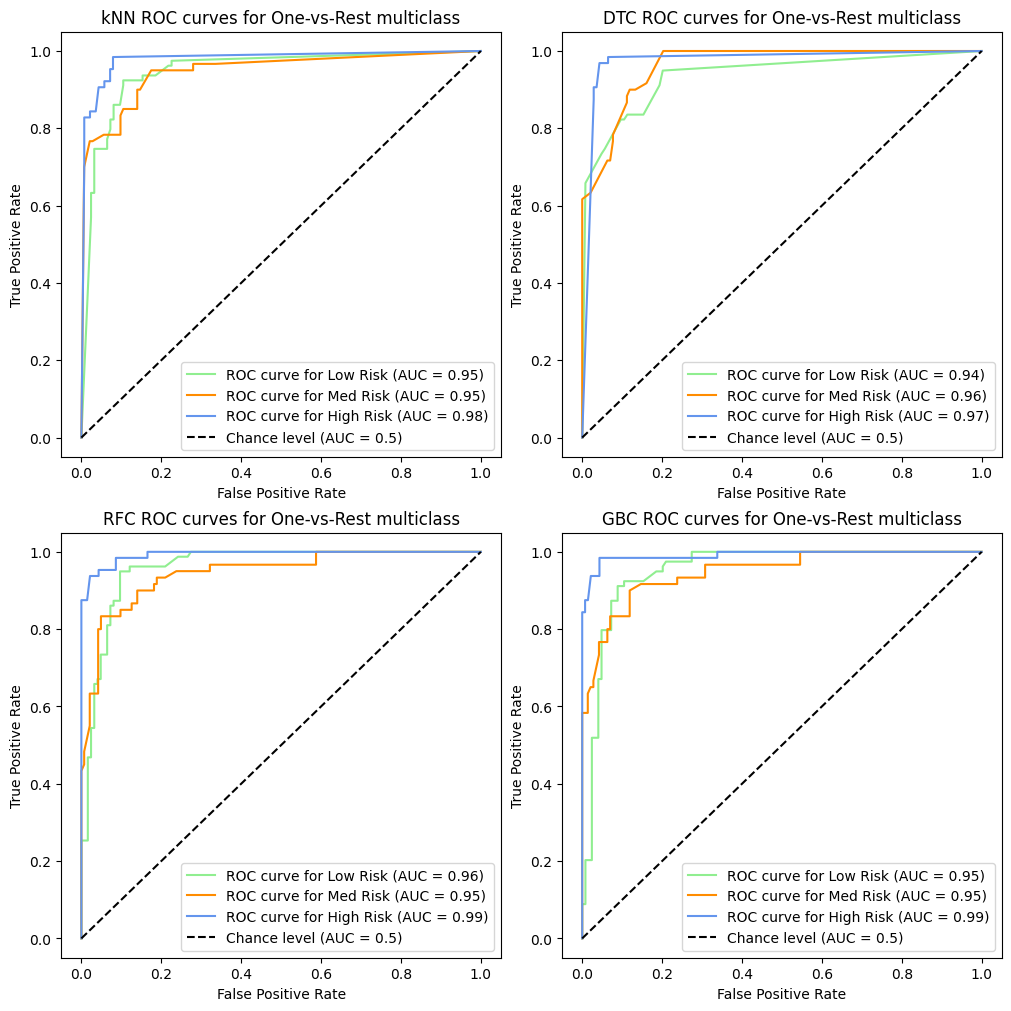

In [50]:
n_classes = len(np.unique(y_train))
colors = ["lightgreen", "darkorange", "cornflowerblue"]
name_dict = {0:"Low Risk", 1:"Med Risk", 2:"High Risk"}

def plot_rocs(x, y, y_score, y_ovr, name):
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_ovr[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {name_dict[class_id]}",
            color=color,
            ax=ax[x][y],
            plot_chance_level=(class_id == 2),
        )
    _ = ax[x][y].set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"{name} ROC curves for One-vs-Rest multiclass",
    ) 
    
fig, ax = plt.subplots(2, 2, constrained_layout=True, figsize=(10,10))
plot_rocs(0,0,y_score_knn,y_ovr_knn,"kNN")
plot_rocs(0,1,y_score_dtc,y_ovr_dtc,"DTC")
plot_rocs(1,0,y_score_rf,y_ovr_rf,"RFC")
plot_rocs(1,1,y_score_gb,y_ovr_gb,"GBC")

### Results Summary
* All 4 models performed similarily when assessing the confusion matrix for each model. Most predictions were labelled corectly with Low Risk and Medium Risk being mixed up the most.
* The Gradient Boosting Classifier performed the best across all score metrics (accuracy, precision, recall, F1) with scores around 0.87 for all metrics.
* The Random Forest Classifier performed second best across all score metrics with scores around 0.86 for all metrics.
* All 4 models had the highest AUC values for the High Risk category.
* The Random Forest Classifier had the highest AUC values for all three categories and the Gradient Boosting Classifier had second highest AUC values over all three categories.
* Overall, the Gradient Boosting Classifier has the highest metrics across the board. It is also the slowest method, so if speed is an issue, the Random Forest Classifier is a faster alternative with very comparable results.

## Discussion and Conclusion

##### Takeaways
* Gradient Boosting Classifier and Random Forest Classifier provided the best models for this dataset.
* It is very important to take into consideration model complexity when choosing models to train as this will greatly effect model run time.
* Learned a lot about how to group plots and create subplots for easier visualization.

##### Troubleshooting
* The hardest challenge of this project was determining which hyperparameters to pick for tuning and what ranges each should be. It was often a guess as to what would be an approriate range.
* Some of the classifier methods were very slow when running with all the hyperparameters. It was difficult to know how long the classifier was going to run and if it was worth it to wait or stop the run early. This also factored into deciding which hyperparameters to pick.

##### Improvements
* Reconstruct this experiment with more data points. There were only around 1000 instances of the data. If there were more data, it would be easier to make some generalizations about the distribution of the data and possibly make better decisions about outliers.
* There was a possible correlation between the BS feature and the RiskLevel target variable. It would be interesting to reconstruct this experiment without the BS feature to see how the models perform.
* Include more types of models when training, like Naive Bayes or even a multiclass Logitic Regression model.